In [1]:
if 1:
    !nvidia-smi
    
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book
    
    from google.colab import drive
    #drive.mount('/content/drive')

Tue May  4 16:27:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.PETS)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [6]:
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [7]:
items = get_image_files(path_hr)

In [8]:
class Crappifier():
    def __init__(self, path_hr, path_lr, size):
        self.path_hr = path_hr
        self.path_lr = path_lr
        self.size = size
        
    def __call__(self, fn):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        target_sz = resize_to(img, self.size, use_min=True)
        img = img.resize(target_sz, resample=Image.BILINEAR).convert('RGB')
        img.save(dest, quality=60)

In [9]:
parallel(Crappifier(path_hr, path_lr, 96), items)
parallel(Crappifier(path_hr, path_mr, 256), items)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

In [10]:
path_lr.ls()

(#7390) [Path('small-96/Persian_186.jpg'),Path('small-96/samoyed_138.jpg'),Path('small-96/saint_bernard_169.jpg'),Path('small-96/pug_191.jpg'),Path('small-96/pomeranian_152.jpg'),Path('small-96/great_pyrenees_19.jpg'),Path('small-96/British_Shorthair_209.jpg'),Path('small-96/chihuahua_2.jpg'),Path('small-96/american_pit_bull_terrier_176.jpg'),Path('small-96/shiba_inu_53.jpg')...]

In [11]:
path_mr.ls()

(#7390) [Path('small-256/Persian_186.jpg'),Path('small-256/samoyed_138.jpg'),Path('small-256/saint_bernard_169.jpg'),Path('small-256/pug_191.jpg'),Path('small-256/pomeranian_152.jpg'),Path('small-256/great_pyrenees_19.jpg'),Path('small-256/British_Shorthair_209.jpg'),Path('small-256/chihuahua_2.jpg'),Path('small-256/american_pit_bull_terrier_176.jpg'),Path('small-256/shiba_inu_53.jpg')...]

In [12]:
path_hr.ls()

(#7393) [Path('images/Persian_186.jpg'),Path('images/samoyed_138.jpg'),Path('images/saint_bernard_169.jpg'),Path('images/pug_191.jpg'),Path('images/pomeranian_152.jpg'),Path('images/great_pyrenees_19.jpg'),Path('images/British_Shorthair_209.jpg'),Path('images/chihuahua_2.jpg'),Path('images/american_pit_bull_terrier_176.jpg'),Path('images/shiba_inu_53.jpg')...]

In [13]:
bs, size = 32, 128
arch = resnet34

In [48]:
def get_dls(path_lr, bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items = get_image_files,
        get_y = lambda x: path_hr/x.name,
        splitter = RandomSplitter(),
        item_tfms = Resize(size),
        batch_tfms = [*aug_transforms(max_zoom=2.)]
    )
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [49]:
dls = get_dls(path_lr, bs, size)

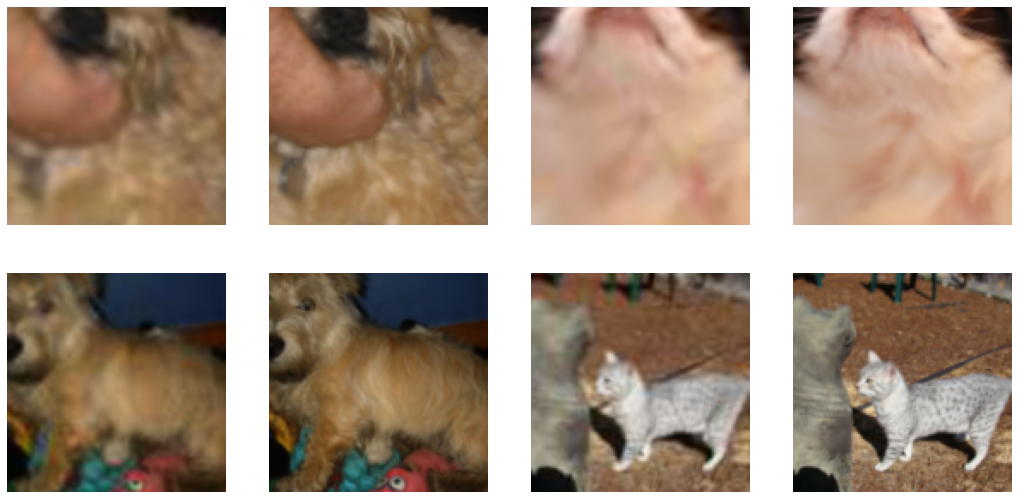

In [16]:
dls.show_batch(max_n=4, figsize=(18,9))

# Feature loss

In [17]:
t = tensor(dls.valid_ds[0][1]).float().permute(2,0,1)/255.
t = torch.stack([t,t])

In [18]:
t.shape

torch.Size([2, 3, 357, 500])

In [19]:
dls.valid_ds

(#1478) [(PILImage mode=RGB size=134x96, PILImage mode=RGB size=500x357),(PILImage mode=RGB size=96x170, PILImage mode=RGB size=281x500),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=144x96, PILImage mode=RGB size=500x333),(PILImage mode=RGB size=96x146, PILImage mode=RGB size=327x500),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=96x128, PILImage mode=RGB size=375x500),(PILImage mode=RGB size=128x96, PILImage mode=RGB size=200x150),(PILImage mode=RGB size=120x96, PILImage mode=RGB size=500x400),(PILImage mode=RGB size=143x96, PILImage mode=RGB size=500x334)...]

In [20]:
dls.valid_ds[0]

(PILImage mode=RGB size=134x96, PILImage mode=RGB size=500x357)

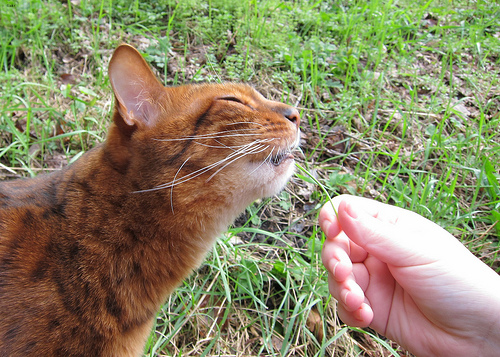

In [21]:
dls.valid_ds[0][1]

In [22]:
tensor(dls.valid_ds[0][1]).shape

torch.Size([357, 500, 3])

In [ ]:
tensor(dls.valid_ds[0][1])

In [ ]:
t

In [25]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [26]:
gram_matrix(t)

tensor([[[0.1136, 0.1084, 0.0866],
         [0.1084, 0.1113, 0.0852],
         [0.0866, 0.0852, 0.0713]],

        [[0.1136, 0.1084, 0.0866],
         [0.1084, 0.1113, 0.0852],
         [0.0866, 0.0852, 0.0713]]])

In [27]:
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [28]:
base_loss = F.l1_loss

In [29]:
vgg_m = vgg16_bn(True).features.cuda().eval()
vgg_m = vgg_m.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [30]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [31]:
blocks[2:5]

[22, 32, 42]

In [50]:
class FeatureLoss(Module): # feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
    def __init__(self, m_feat, layer_ids, layer_wgts):
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target, reduction=reduction)]
        self.feat_losses += [base_loss(f_in, f_out, reduction=reduction)*w 
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out), reduction=reduction)*w**2 * 5e3 
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        if reduction=='none':
          self.feat_losses = [f.mean(dim=[1,2,3]) for f in self.feat_losses[:4]] + [f.mean(dim=[1,2]) for f in self.feat_losses[4:]]
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        return sum(self.feat_losses)
        
    def __del__(self): 
        self.hooks.remove()

In [51]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [52]:
learn = unet_learner(dls, arch, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
                    blur=True, norm_type=NormType.Weight)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0010000000474974513)

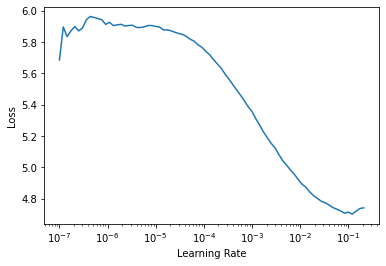

In [53]:
learn.lr_find()

In [54]:
lr = 1e-3
wd = 1e-3

In [62]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
  learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
  learn.save(save_name)
  learn.show_results(ds_idx=1, max_n=2, figsize=(15,11))

In [56]:
path_drive_models = '/content/drive/MyDrive/Deep_Learning_from_the_Foundations/models'

In [58]:
do_fit(path_drive_models + '1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.169489,3.444873,0.121428,0.214901,0.296788,0.209819,0.524568,1.124732,0.952637,01:53
1,3.043276,3.339527,0.118572,0.213564,0.288695,0.201079,0.512033,1.095129,0.910455,01:53
2,2.950396,3.272844,0.116222,0.209907,0.282931,0.196151,0.503846,1.074472,0.889315,01:53
3,2.920329,3.238131,0.124788,0.208593,0.279609,0.194587,0.491819,1.054360,0.884375,01:53
4,2.871358,3.188622,0.115973,0.207165,0.276439,0.192455,0.475204,1.045855,0.875532,01:53
5,2.846831,3.113998,0.122799,0.207816,0.274580,0.187589,0.450361,1.019942,0.850913,01:53
6,2.817012,3.083816,0.119397,0.204561,0.270633,0.184962,0.452953,1.008902,0.842408,01:53
7,2.785871,3.052014,0.111077,0.203480,0.268851,0.183207,0.448688,1.004531,0.832180,01:53
8,2.785510,3.068955,0.114895,0.204301,0.269950,0.184051,0.451677,1.008087,0.835994,01:53
9,2.681997,2.947781,0.105633,0.200225,0.261651,0.176999,0.426216,0.972181,0.804876,01:53


TypeError: ignored

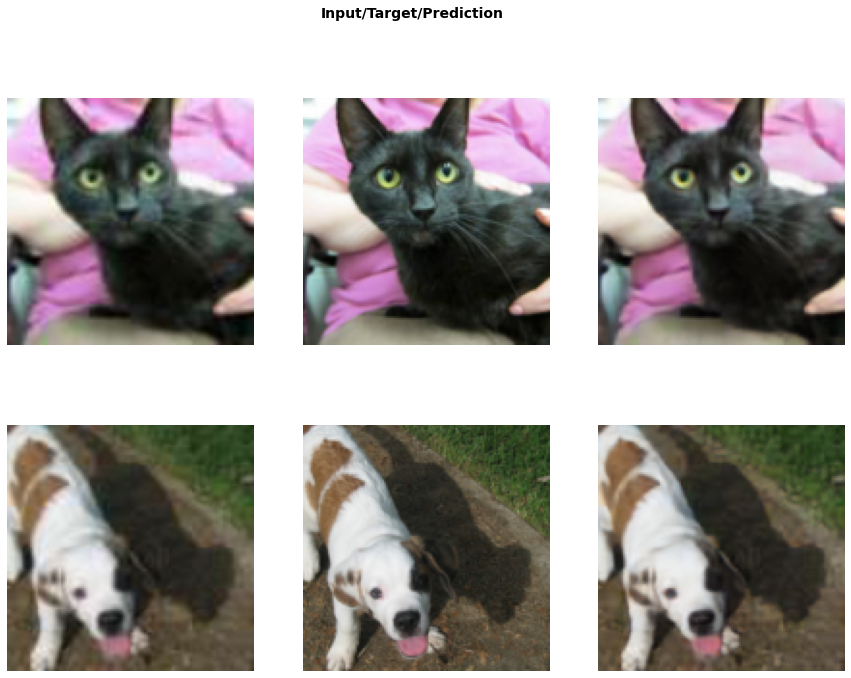

In [60]:
learn.show_results(max_n=2, figsize=(15,11))

In [61]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.662785,2.945844,0.105481,0.199783,0.261459,0.176895,0.426406,0.971326,0.804493,01:57
1,2.666262,2.941187,0.105423,0.199585,0.261048,0.176422,0.426780,0.969610,0.802320,01:57
2,2.659080,2.936910,0.105597,0.199411,0.260792,0.176248,0.424847,0.967830,0.802185,01:57
3,2.651454,2.932460,0.105703,0.199305,0.260450,0.176030,0.423315,0.966281,0.801376,01:57
4,2.648888,2.930708,0.105708,0.199187,0.260118,0.175905,0.423669,0.965474,0.800646,01:57
5,2.641817,2.915372,0.105041,0.198759,0.259256,0.175087,0.419700,0.961186,0.796344,01:57
6,2.639055,2.907706,0.105746,0.199153,0.259491,0.174266,0.417519,0.959731,0.791801,01:57
7,2.626018,2.918699,0.105976,0.198069,0.258756,0.174893,0.423969,0.961199,0.795838,01:57
8,2.627492,2.913883,0.105093,0.198724,0.259110,0.174615,0.421576,0.961290,0.793475,01:57
9,2.622368,2.886428,0.104928,0.197862,0.257584,0.173144,0.413285,0.952196,0.787430,01:57


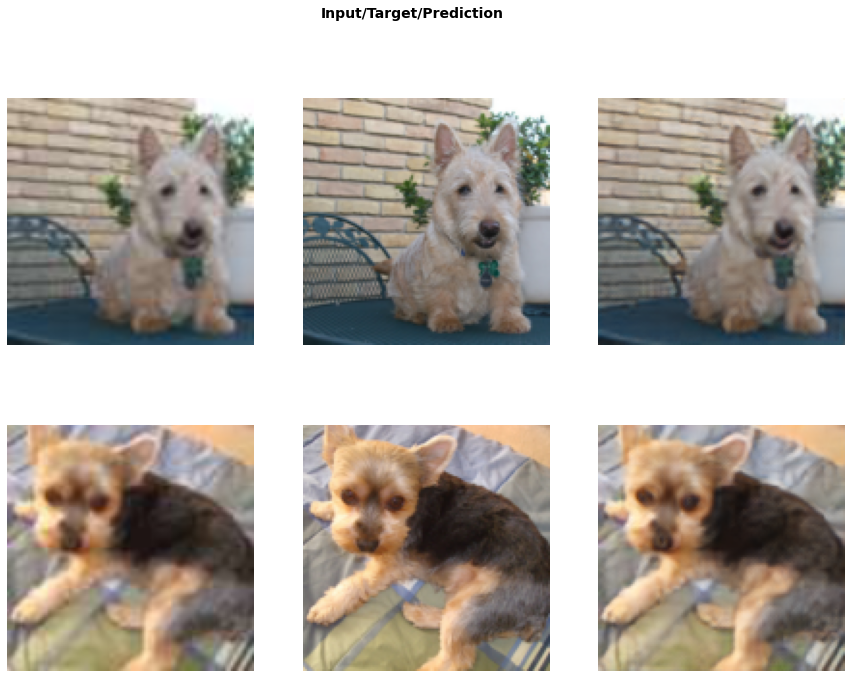

In [63]:
do_fit(path_drive_models + '1b', slice(1e-5, lr))

In [64]:
dls = get_dls(path_lr, 12, size *2)

TypeError: ignored